# Unsupervised outliers detection (event detection)

In [1]:
import sys 
sys.path.insert(0,'../')
import pymce2 as mce

import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA,TruncatedSVD,NMF,FastICA
from sklearn.metrics import roc_auc_score

import matplotlib.pylab as plt
from matplotlib import gridspec
%matplotlib inline

## Defining clustering algorithm as clustering fucntion

In [2]:
agg = AgglomerativeClustering()

## Signal synthesis

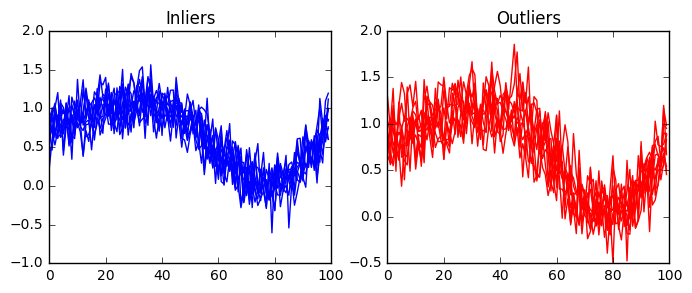

In [3]:
i_sig = 1
n_ftrs = 100
noise = 0.2
scl = 0.0
sft = 0.0

X, y = mce.synt_event(i_sig,n_ftrs,sigma = noise,n1 = scl,n2 = sft,n3 = scl,n4 = sft)

gs = gridspec.GridSpec(1, 2)
plt.figure(figsize=(8,3)) 
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax1.set_title('Inliers')
ax2.set_title('Outliers')

inliers = X[y==0]
outliers = X[y==1]
for i in range(10):
    ax1.plot(inliers[i],'b')
    ax2.plot(outliers[i],'r')

## Outlier detection using auto encoders

In [4]:
z_dim = 2
dim_rs ={'AE':'AE','VAE':'VAE','none':'none','PCA':PCA(n_components=z_dim),'NMF':NMF(n_components=2), 
         'FastICA':FastICA(n_components=2, max_iter=1000)}
# dim_rs ={'PCA':PCA(n_components=z_dim)}

metrics = ['correlation','mahalanobis','L2']
for dim_r, value in dim_rs.iteritems():
    
    print '---------------  '+dim_r+'  ----------------'

    # Splitter definition
    splitter = mce.Splitter(X, reducer = value, clustering = agg.fit_predict, z_dim=z_dim)

    # Splitting
    splitter.split(1,verbose=0,training_epochs=20)
    
    # outlier extraction for all of requeste metrics
    outliers_r = mce.outliers(X,splitter,mce.metrics)
    outliers_l = mce.outliers_latent(splitter,metrics) 
    
    for metr in metrics:
        print '{:<12}: real:{:2.2f}, latent:{:2.2f}'.format(metr,roc_auc_score(y==1, outliers_r[metr]),
                                              roc_auc_score(y==1, outliers_l[metr]))

        
    # ensembling
#     ems_outliers = mce.norm_ensemble(outliers,0.1)
    
#     # AUC
#     auc = roc_auc_score(y==1, ems_outliers)

#     print '{}: AUC={:4.2f}'.format(dim_r,auc)

        
#     print '*********************************************'

---------------  none  ----------------
correlation : real:0.62, latent:0.62
mahalanobis : real:0.43, latent:0.43
L2          : real:0.92, latent:0.92
---------------  AE  ----------------
correlation : real:0.56, latent:0.50
mahalanobis : real:0.61, latent:0.50
L2          : real:0.98, latent:0.50
---------------  VAE  ----------------
correlation : real:0.63, latent:0.52
mahalanobis : real:0.91, latent:0.65
L2          : real:0.98, latent:0.65
---------------  NMF  ----------------
correlation : real:0.62, latent:0.48
mahalanobis : real:0.90, latent:0.96
L2          : real:0.96, latent:0.93
---------------  FastICA  ----------------
correlation : real:0.62, latent:0.62
mahalanobis : real:0.89, latent:0.95
L2          : real:0.96, latent:0.97
---------------  PCA  ----------------
correlation : real:0.63, latent:0.49
mahalanobis : real:0.89, latent:0.93
L2          : real:0.95, latent:0.93


In [ ]:
---------------  none  ----------------
correlation : real:0.94, latent:0.94
mahalanobis : real:0.99, latent:0.41
L2          : real:0.87, latent:1.00
---------------  AE  ----------------
correlation : real:0.63, latent:0.50
mahalanobis : real:0.83, latent:0.50
L2          : real:0.99, latent:0.50
---------------  VAE  ----------------
correlation : real:0.96, latent:0.48
mahalanobis : real:0.88, latent:0.60
L2          : real:0.95, latent:0.60
---------------  NMF  ----------------
correlation : real:0.94, latent:0.51
mahalanobis : real:0.79, latent:0.96
L2          : real:0.88, latent:0.91
---------------  FastICA  ----------------
correlation : real:0.93, latent:0.51
mahalanobis : real:0.88, latent:0.93
L2          : real:0.88, latent:0.96
---------------  PCA  ----------------
correlation : real:0.94, latent:0.55
mahalanobis : real:0.97, latent:0.62
L2          : real:0.92, latent:1.00

## Outlier detection using Scikit-learn dimensionality reduction classes

In [5]:
dim_rs ={'PCA':PCA(n_components=2),
         'NMF':NMF(n_components=2), 
         'FastICA':FastICA(n_components=2, max_iter=1000)}

for dim_r, value in dim_rs.iteritems():
    
    print '---------------  '+dim_r+'  ----------------'

    # Splitter definition using Scikit-learn dimensionality reduction classes
    splitter = mce.Custom_Splitter(X, mce.sk_convert(value), clustering)

    # Splitting
    splitter.split(1,verbose=0)
    
    # outlier extraction for all of requeste metrics
    outliers = mce.outliers(X,splitter,metrics)
        
    # ensembling
    ems_outliers = mce.norm_ensemble(outliers,0.1)
    
    # AUC
    auc = roc_auc_score(y==1, ems_outliers)

    print '{}: AUC={:4.2f}'.format(dim_r,auc)

    print '...........     metric report     ...........'
    print 
    for metr in metrics:
        print metr,roc_auc_score(y==1, outliers[metr])
        
    print '*********************************************'

---------------  NMF  ----------------
NMF: AUC=0.87
...........     metric report     ...........

cityblock 0.895875
L2 0.9086
L4 0.89629
braycurtis 0.750955
canberra 0.54297
chebyshev 0.7888
correlation 0.921615
mahalanobis 0.84203
wL2 0.923945
wL4 0.91154
*********************************************
---------------  PCA  ----------------
PCA: AUC=0.97
...........     metric report     ...........

cityblock 0.98699
L2 0.972135
L4 0.945225
braycurtis 0.95363
canberra 0.60455
chebyshev 0.83529
correlation 0.91502
mahalanobis 0.95359
wL2 0.945895
wL4 0.86235
*********************************************
---------------  FastICA  ----------------
FastICA: AUC=0.85
...........     metric report     ...........

cityblock 0.897925
L2 0.908235
L4 0.894785
braycurtis 0.757515
canberra 0.541015
chebyshev 0.793305
correlation 0.927155
mahalanobis 0.95359
wL2 0.752055
wL4 0.75392
*********************************************


In [6]:
class foo(object):
    def __init__(self):
        self.i = 0
    def bar(self):
        self.i += 1
        print self.i
        
    def __enter__(self):
#         self.__init__()
        return self
    def __exit__(self, type, value, traceback):
        del self.i

In [60]:
ins = foo()

In [8]:
with foo() as ss:
    ss.bar()

1


In [5]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering as AggC
from memory_profiler import memory_usage
from time import time

In [6]:
n_f = 200
n_d = 1000
x = np.concatenate((np.random.normal(0,0.5,(n_d,n_f)),np.random.normal(4,0.5,(n_d,n_f))),axis=0)
agg = AggC()

t0 = time()
mem_usage = memory_usage((agg.fit_predict, (x,)))
t1 = time()

print('Maximum memory usage: %s' % max(mem_usage))
print  t1-t0

Maximum memory usage: 270.4453125
0.848078012466


In [10]:
for i in splitter.z_mu:
    print mce.Cov_mat(i).shape

(3, 3)
(3, 3)
(3, 3)
(3, 3)


In [36]:
import pickle

def pklread(name):
    with open(name,'r') as f:
        data = pickle.load(f)
    return data

typ = 'event'
for i in range(1,11):
    d = pklread('../../code/corr_res/'+typ+'_cor'+str(i))
    cor1 = d[0]
    cor2 = d[1]
    names = d[2]

    fig = plt.figure(figsize=(18, 9))
    gs = gridspec.GridSpec(1,2)
    ax = fig.add_subplot(gs[0,0])
    ax.imshow(cor1,interpolation='none')
    ax.set_xticks(np.arange(50));
    ax.set_xticklabels(names, rotation='vertical');
    ax.set_yticks(np.arange(50));
    ax.set_yticklabels(names);
    ax.set_title('Correlation');

    ax = fig.add_subplot(gs[0,1])
    ax.imshow(cor2,interpolation='none')
    ax.set_xticks(np.arange(50));
    ax.set_xticklabels(names, rotation='vertical');
    ax.set_yticks(np.arange(50));
    ax.set_yticklabels(names);
    ax.set_title('Cohen-Kappa');

    ax.set_yticks(np.arange(50));
    ax.set_yticklabels(names);
    plt.subplots_adjust(wspace=0.23,bottom=0.17, top=0.97, left=0.09, right=0.99)
    plt.savefig('cm_'+typ+str(i)+'.jpg',dpi=200)
    plt.close()

In [9]:
ss = np.arange(4)